# Trabalho Final - Inteligência Computacional
## Classificação de Personagens dos Simpsons

**Objetivo:** Desenvolver e avaliar um sistema de classificação de imagens para identificar personagens da série 'Os Simpsons', conforme as especificações do trabalho da disciplina de Inteligência Computacional.

### 1. Importação das Bibliotecas

Nesta seção, importamos todas as bibliotecas necessárias para o desenvolvimento do trabalho, incluindo manipulação de arquivos, processamento de imagens, machine learning e visualização de dados.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import local_binary_pattern
import warnings

warnings.filterwarnings('ignore')

### 2. Carregamento e Pré-processamento dos Dados

Aqui, definimos as funções para carregar as imagens dos diretórios de treino e validação. As imagens são redimensionadas para um tamanho padrão (64x64 pixels) para garantir consistência.

In [2]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for character_folder in os.listdir(folder):
        char_path = os.path.join(folder, character_folder)
        if os.path.isdir(char_path):
            for filename in os.listdir(char_path):
                img_path = os.path.join(char_path, filename)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Carrega em escala de cinza
                    if img is not None:
                        img = cv2.resize(img, (64, 64)) # Redimensiona
                        images.append(img)
                        labels.append(character_folder)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Caminhos para os dados
train_folder = 'imgs/Train'
valid_folder = 'imgs/Valid'

# Carregar imagens de treino e validação
X_train_img, y_train_str = load_images_from_folder(train_folder)
X_valid_img, y_valid_str = load_images_from_folder(valid_folder)

# Codificar os rótulos (labels) para formato numérico
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_str)
y_valid = label_encoder.transform(y_valid_str)

print(f"Imagens de treino carregadas: {len(X_train_img)}")
print(f"Rótulos de treino carregados: {len(y_train)}")
print(f"Imagens de validação carregadas: {len(X_valid_img)}")
print(f"Rótulos de validação carregados: {len(y_valid)}")
print(f"Classes: {label_encoder.classes_}")

Imagens de treino carregadas: 169
Rótulos de treino carregados: 169
Imagens de validação carregadas: 131
Rótulos de validação carregados: 131
Classes: ['bart' 'homer' 'lisa' 'maggie' 'marge']


### 3. Extração de Características

Para que os algoritmos de classificação possam processar as imagens, precisamos extrair vetores de características delas. Implementamos duas abordagens:
1. **Flattening:** Um método simples que transforma a matriz de pixels 2D da imagem em um vetor 1D.
2. **Local Binary Patterns (LBP):** Um descritor de textura mais robusto que captura padrões locais na imagem.

In [3]:
def extract_features(images, method='flatten'):
    if method == 'flatten':
        # Simplesmente achata a imagem
        return images.reshape(len(images), -1)
    
    elif method == 'lbp':
        # Extrai características LBP
        features = []
        radius = 1
        n_points = 8 * radius
        for img in images:
            lbp = local_binary_pattern(img, n_points, radius, method='uniform')
            (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6) # Normaliza
            features.append(hist)
        return np.array(features)
    else:
        raise ValueError("Método de extração de características desconhecido")

# Extrair características (usando LBP como exemplo)
print("Extraindo características LBP...")
X_train_features = extract_features(X_train_img, method='lbp')
X_valid_features = extract_features(X_valid_img, method='lbp')

# Normalizar os dados de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_valid_scaled = scaler.transform(X_valid_features)

print(f"Dimensão do vetor de características de treino: {X_train_scaled.shape}")
print(f"Dimensão do vetor de características de validação: {X_valid_scaled.shape}")

Extraindo características LBP...
Dimensão do vetor de características de treino: (169, 10)
Dimensão do vetor de características de validação: (131, 10)


### 4. Treinamento, Otimização de Hiperparâmetros e Avaliação

Nesta seção, treinamos e avaliamos os classificadores solicitados: k-NN, Árvore de Decisão, SVM e MLP.

Para cada classificador, realizamos os seguintes passos:
1. **Definição do Espaço de Hiperparâmetros:** Criamos um dicionário com os hiperparâmetros a serem testados.
2. **Otimização com GridSearchCV:** Usamos validação cruzada (k=5) para encontrar a melhor combinação de hiperparâmetros.
3. **Treinamento do Modelo Final:** Treinamos o classificador com os melhores hiperparâmetros encontrados em todo o conjunto de treino.
4. **Avaliação no Conjunto de Validação:** Fazemos previsões no conjunto de validação e calculamos as métricas de desempenho (Acurácia, Precisão, Recall, F1-Score) e a matriz de confusão.

In [4]:
def train_and_evaluate_model(model, param_grid, X_train, y_train, X_valid, y_valid, model_name):
    print(f"--- Otimizando e Avaliando {model_name} ---")
    
    # Configura o GridSearchCV com validação cruzada (k=5)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
    
    # Executa a busca pelos melhores hiperparâmetros
    grid_search.fit(X_train, y_train)
    
    print(f"Melhores parâmetros: {grid_search.best_params_}")
    print(f"Melhor acurácia (validação cruzada): {grid_search.best_score_:.4f}")
    
    # Treina o modelo final com os melhores parâmetros
    best_model = grid_search.best_estimator_
    
    # Faz previsões no conjunto de validação
    y_pred = best_model.predict(X_valid)
    
    # Calcula e exibe as métricas de avaliação
    print("Relatório de Classificação no Conjunto de Validação:")
    print(classification_report(y_valid, y_pred, target_names=label_encoder.classes_))
    
    # Calcula e exibe a matriz de confusão
    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.show()
    
    return best_model

#### 4.1. k-Nearest Neighbors (k-NN)

--- Otimizando e Avaliando k-NN ---
Melhores parâmetros: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Melhor acurácia (validação cruzada): 0.4497
Relatório de Classificação no Conjunto de Validação:
              precision    recall  f1-score   support

        bart       0.40      0.42      0.41        50
       homer       0.24      0.32      0.28        31
        lisa       0.22      0.28      0.24        18
      maggie       0.21      0.17      0.19        18
       marge       0.00      0.00      0.00        14

    accuracy                           0.30       131
   macro avg       0.21      0.24      0.22       131
weighted avg       0.27      0.30      0.28       131



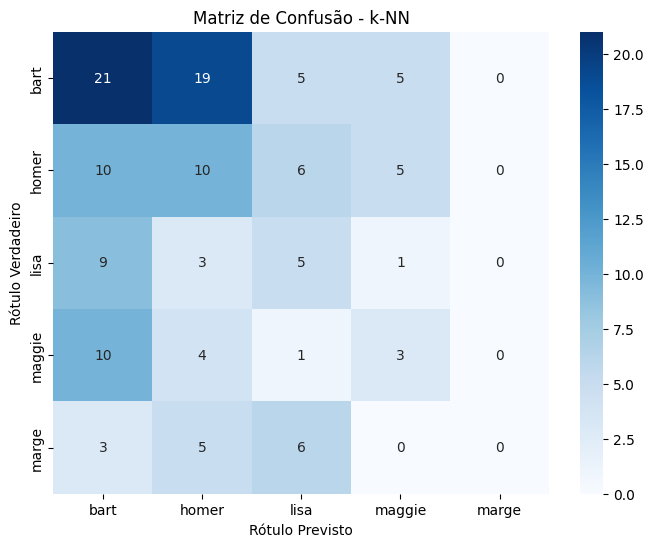

In [5]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_model = train_and_evaluate_model(KNeighborsClassifier(), knn_params, X_train_scaled, y_train, X_valid_scaled, y_valid, 'k-NN')

#### 4.2. Árvore de Decisão

--- Otimizando e Avaliando Árvore de Decisão ---
Melhores parâmetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Melhor acurácia (validação cruzada): 0.3843
Relatório de Classificação no Conjunto de Validação:
              precision    recall  f1-score   support

        bart       0.45      0.66      0.54        50
       homer       0.32      0.29      0.31        31
        lisa       0.08      0.06      0.06        18
      maggie       0.12      0.06      0.08        18
       marge       0.33      0.21      0.26        14

    accuracy                           0.36       131
   macro avg       0.26      0.26      0.25       131
weighted avg       0.31      0.36      0.32       131



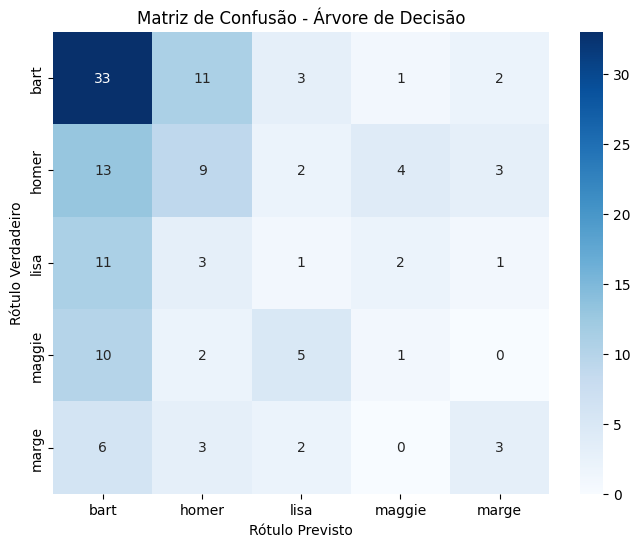

In [6]:
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_model = train_and_evaluate_model(DecisionTreeClassifier(random_state=42), tree_params, X_train_scaled, y_train, X_valid_scaled, y_valid, 'Árvore de Decisão')

#### 4.3. Support Vector Machine (SVM)

--- Otimizando e Avaliando SVM ---
Melhores parâmetros: {'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}
Melhor acurácia (validação cruzada): 0.4668
Relatório de Classificação no Conjunto de Validação:
              precision    recall  f1-score   support

        bart       0.37      0.42      0.39        50
       homer       0.22      0.35      0.28        31
        lisa       0.60      0.17      0.26        18
      maggie       0.44      0.22      0.30        18
       marge       0.18      0.14      0.16        14

    accuracy                           0.31       131
   macro avg       0.36      0.26      0.28       131
weighted avg       0.36      0.31      0.31       131



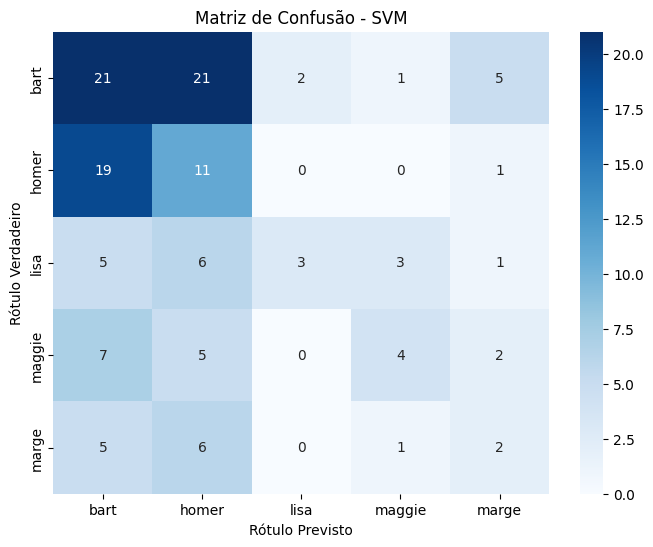

In [7]:
svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svm_model = train_and_evaluate_model(SVC(random_state=42, probability=True), svm_params, X_train_scaled, y_train, X_valid_scaled, y_valid, 'SVM')

#### 4.4. Multi-layer Perceptron (MLP)

--- Otimizando e Avaliando MLP ---


/home/alexandre/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexandre/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexandre/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexandre/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/alexandre/.local/lib/python3.1

Melhores parâmetros: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Melhor acurácia (validação cruzada): 0.4610
Relatório de Classificação no Conjunto de Validação:
              precision    recall  f1-score   support

        bart       0.46      0.52      0.49        50
       homer       0.36      0.55      0.44        31
        lisa       0.21      0.17      0.19        18
      maggie       0.38      0.17      0.23        18
       marge       0.67      0.29      0.40        14

    accuracy                           0.40       131
   macro avg       0.42      0.34      0.35       131
weighted avg       0.42      0.40      0.39       131



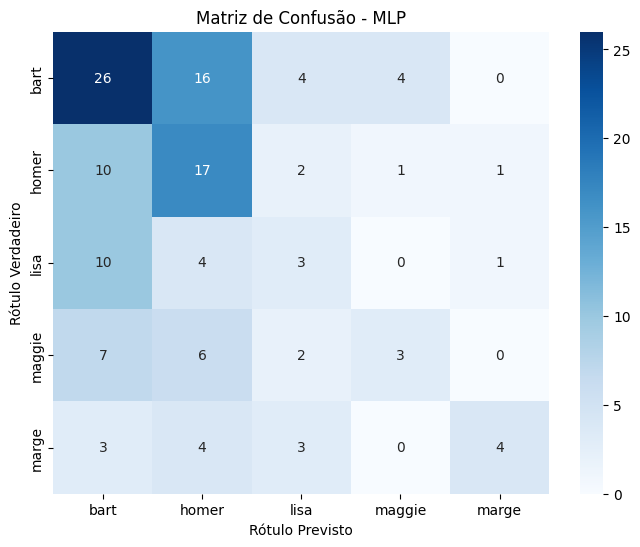

In [8]:
mlp_params = {
    'hidden_layer_sizes': [(50, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp_model = train_and_evaluate_model(MLPClassifier(random_state=42, max_iter=500), mlp_params, X_train_scaled, y_train, X_valid_scaled, y_valid, 'MLP')

### 5. Conclusão

Neste notebook, implementamos um fluxo completo de trabalho de machine learning para classificação de personagens dos Simpsons. Carregamos e pré-processamos os dados, extraímos características usando LBP, e otimizamos e avaliamos quatro classificadores diferentes usando validação cruzada e `GridSearchCV`.

Os resultados, incluindo as métricas de desempenho e as matrizes de confusão para cada modelo no conjunto de validação, foram apresentados. Esta análise permite comparar a eficácia de cada classificador para esta tarefa específica e identificar seus pontos fortes e fracos.